<a href="https://colab.research.google.com/github/AliceKa/hello-world/blob/master/VGG_new16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1UbVE0_WzBkPsqFzBboTiFgxVwl2nufJc'})
download.GetContentFile('DOWNLOAD1.zip')

In [5]:
len(open('media/train.txt').readlines())

117263

In [1]:
list_of_image_names = [string.split()[0] for string in open('media/train.txt','r').readlines()]
list_of_image_labels = [string.split()[1] for string in open('media/train.txt','r').readlines()]
len(list_of_image_labels)/3026

38.75181758096497

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
import numpy as np
import h5py
import math
import time
from random import shuffle
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected, l2_regularizer
from tensorflow.contrib.framework import arg_scope
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [0]:
def normalize_and_write_data_into_h5_file(dest_filepath, filepaths_list, n_px, n_channels = 3):
    
    '''
        This function converts images to numpy arrays and writes the array data into a h5 file.
        
        dest_filepath - the name of the file with full path that is being created
        filepaths_list - source image file paths which is being converted to numpy arrays
        n_px - number of pixels - will be used as image's height and width
        n_channels - 3 for rgb
    '''
    
    data_shape = (len(filepaths_list), n_px * n_px * n_channels)
    dataset_name = "input_data"
    
    with h5py.File(dest_filepath, 'w') as f:
        
        f.create_dataset('input_data', data_shape, np.float32)
        
        for i in range(len(filepaths_list)):
            #if (i+1) % 512 == 0:
            #    print('{}/{} files converted'.format((i+1), len(filepaths_list)))

            filepath = filepaths_list[i]
            img = cv2.imread('media/'+filepath)
            #img = cv2.resize(img, (n_px, n_px), interpolation=cv2.INTER_CUBIC)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            #Normalize the image - convert the each pixel value between 0 and 1
            img = img / 255
            #Reshape the image - roll it up into a column vector
            img = img.ravel()
            
            #img[None] makes it a proper array instead of rank 1 array
            f[dataset_name][i, ...] = img[None]

In [0]:
def write_labels_into_h5_file(dest_filepath, labels):
    
    dataset_name = "input_labels"
    labels = np.array(labels, dtype=np.int8)
    with h5py.File(dest_filepath, 'a') as f:            
        f.create_dataset('input_labels', (len(labels),), np.int8)
        f[dataset_name][...] = labels

In [0]:
def convert_images_to_data_in_h5_file(dest_h5_file_path, n_px, 
                                      n_channels = 3, batch_size = 3024):
    
    #Returns a list of filepaths matching the pattern given as parameter
    src_filepaths = list_of_image_names
    
    #Create Labels based upon the substring contained in the filename
    labels = list_of_image_labels
    
    
    #The zip(source_filepaths, labels) combines each element of source_filepaths list 
    #with each element of labels list forming a pair (tuple). t is the list which contains these tuples
    t = list(zip(src_filepaths, labels))

    #Shuffle the list
    shuffle(t)
    
    #Get the shuffled filepaths & labels
    src_filepaths, labels = zip(*t)
    
    #Number of images
    m = len(src_filepaths) 
    n_complete_batches = math.ceil(m / batch_size)
    
    for i in range(2):
        print('Creating file', (i+1))
        
        dest_file_path = str(dest_h5_file_path) + str(i + 1) + ".h5"  
        
        start_pos = i * batch_size
        end_pos = min(start_pos + batch_size, m)
        src_filepaths_batch = src_filepaths[start_pos: end_pos]
        labels_batch = labels[start_pos: end_pos]
        normalize_and_write_data_into_h5_file(dest_file_path, src_filepaths_batch, n_px)
        write_labels_into_h5_file(dest_file_path, labels_batch)

H5py file creation https://github.com/selvam85/Cat-Dog-Classifier/blob/master/DNN_using_plain_TF_Cat_vs_Dog_classifier_Kaggle_dataset/Convert%20Images%20to%20Numpy%20array%20and%20save%20in%20h5%20fomat%20v2.1.ipynb

Usage of batches in sess. https://github.com/selvam85/Cat-Dog-Classifier/blob/master/DNN_using_plain_TF_Cat_vs_Dog_classifier_Kaggle_dataset/DNN%20using%20plain%20TF%20-%20Cat%20vs%20Dog%20classifier_Colab%20file_v2.0.ipynb

Explanation https://medium.com/@toselvam/how-to-work-with-large-training-dataset-in-google-colab-platform-c3499fc10c24

Batch usage https://github.com/ghwatson/faststyle/blob/master/libs/vgg16.py

In [6]:
dest_filepath = 'train_set'
n_px = 256
n_channels = 3

tic = time.process_time()
convert_images_to_data_in_h5_file(dest_filepath, n_px, n_channels)
toc = time.process_time()
print('Time taken for creating the h5 file is', (toc-tic)*1000, 'ms')

Creating file 1
Creating file 2
Time taken for creating the h5 file is 21344.637015 ms


Uploading the h5py files into Google Drive for the future usage 

In [7]:
destination_filepath = 'train_set1.h5'
with h5py.File(destination_filepath, "r") as f:
    
    print(list(f.keys()))
    
    x = f["input_data"][:]
    y = f["input_labels"][:]

    print('x shape =', x.shape, '| y shape =', y.shape)
    print('Number of classes presented =', len(set(y)))

['input_data', 'input_labels']
x shape = (3024, 196608) | y shape = (3024,)
Number of classes presented = 38


(196608,)
y = 37


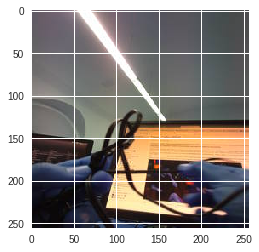

In [8]:
index = 0
image = x[index]
print(image.shape)
image = (x[index]).reshape(256, 256, 3)
#print(image)
#print(image.shape)
plt.imshow(image)
print('y =', y[index])

In [9]:
len(set(y))

38

###Second part of the assignment - VGG training with the h5 files created

In [10]:
import tensorflow as tf
import numpy as np
import h5py
import math
import time
from random import shuffle
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected, l2_regularizer
from tensorflow.contrib.framework import arg_scope
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [0]:
def load_dataset():
    
    lmd_tic = time.time()
    
    X_full_dataset = []
    Y_full_dataset = []
    filename_prefix = 'train_set'
    
    for i in range(1, 3):
        
        filename = filename_prefix + str(i) + ".h5"
        with h5py.File(filename, "r") as f:
    
            X_full_dataset.append(f["input_data"][:])
            Y_full_dataset.append(f["input_labels"][:])

    lmd_toc = time.time()
    print('Time taken to load the data set is', ((lmd_toc-lmd_tic) * 1000), 'ms')
    
    return X_full_dataset, Y_full_dataset

In [0]:
def get_shuffled_indices(start_value, last_value):
    
    temp = np.arange(start_value, last_value)
    shuffle(temp)
    
    return temp

In [0]:
from keras.utils import to_categorical

In [0]:
def create_random_mini_batches(X, Y, n_classes = 39, mini_batch_size = 32):
    
    m = X.shape[0] # number of training examples
    mini_batches = []
    
    #Reshaping to convert Y to a 2D array from a rank one array
    #Y = Y.reshape(Y.shape[0], 1)
    Y = to_categorical(Y)
    
    #Shuffle the data in each of the mini batch
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]
    
    n_mini_batches = math.ceil(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(n_mini_batches):
        
        start_pos = k * mini_batch_size
        end_pos = min(start_pos + mini_batch_size, m)
        
        mini_batch_X = shuffled_X[start_pos : end_pos, :]
        mini_batch_Y = shuffled_Y[start_pos : end_pos, :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

One hot encoding https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d

In [0]:
def create_placeholders(n_inputs):
    '''
    n_inputs - A scalar containing the number of input features
    '''
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
    Y = tf.placeholder(tf.float32, shape = (None, 39), name = 'Y')
    
    return X, Y

In [0]:
def nn_model(X, n_neurons):
    '''
    X - input Tensor X
    n_neurons - A scalar containing the number of neurons in each layer including both hidden layers and output layer 
    '''
    hidden_layer_1 = fully_connected(X, n_neurons['hidden_layer_1'], scope = 'hidden_layer_1')
    hidden_layer_2 = fully_connected(hidden_layer_1, n_neurons['hidden_layer_2'], scope = 'hidden_layer_2')
    hidden_layer_3 = fully_connected(hidden_layer_2, n_neurons['hidden_layer_3'], scope = 'hidden_layer_3')
    hidden_layer_4 = fully_connected(hidden_layer_3, n_neurons['hidden_layer_4'], scope = 'hidden_layer_4')
    hidden_layer_5 = fully_connected(hidden_layer_4, n_neurons['hidden_layer_5'], scope = 'hidden_layer_5')
    logits = fully_connected(hidden_layer_5, n_neurons['output_layer'], activation_fn = None, scope = 'output_layer')
    
    return logits

In [0]:
def compute_cost(labels, logits):
    '''
    labels - label tensor Y
    logits - Tensor containing the values of the output layer before passing to the activation function
    '''
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    cost = tf.reduce_mean(cross_entropy, name = 'cost')
    
    return cost

In [0]:
def optimizer(learning_rate, cost):
    '''
    learning_rate - A scalar value containing the learning rate for the backpropagation step
    cost - Overall cost from the forward propagation step for one set of mini batch instance
    '''
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost)
    
    return training_op

In [0]:
def evaluate_model(logits, Y):
    '''
    logits - An array containing the values from the output layer
    Y - An array containing the labels
    '''
    
    #Compute the probability using the sigmoid function
    y_pred = tf.nn.sigmoid(logits)
    #Convert it to 0 or 1 class based on the probability and cast it to integer
    y_pred = tf.cast(y_pred > 0.5, tf.int64)
    #y_pred = tf.cast(tf.round(y_pred), tf.int64)
    
    #Create a boolean tensor by comparing the model prediction against the labels
    correct_prediction = tf.equal(y_pred, tf.cast(Y, tf.int64))
    #Compute the accuracy across all the instances
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

In [0]:
def train_model(n_neurons, n_inputs, learning_rate = 0.01, mini_batch_size = 32, n_epochs = 20, 
                print_cost = True, print_metrics = True):
    
    tf.reset_default_graph()
    
    #Declare and initialize the required variables
    costs = []
    
    #Create Placeholder
    X, Y = create_placeholders(n_inputs)
    
    #Create the nn_model
    logits = nn_model(X, n_neurons) 
    
    #Compute the cost
    cost = compute_cost(Y, logits)
    
    #Optimize the cost using Gradient Descent Optimizer
    training_op = optimizer(learning_rate, cost)
    
    #Evaluate the model
    accuracy = evaluate_model(logits, Y)
    
    #Initialize the variables
    init = tf.global_variables_initializer()
    
    #Create the Saver object
    saver = tf.train.Saver()
    
    #Execute the Graph - Train the model
    with tf.Session() as sess:
        init.run()
        
        X_full_dataset, Y_full_dataset = load_dataset()
        
        for epoch in range(1, n_epochs + 1):
            n_mini_batches = 0
            epoch_cost = 0
            total_time_taken_to_create_mini_batches = 0
            
            tic = time.time()
            
            shuffled_indices = get_shuffled_indices(0, 2)
            for j in shuffled_indices:
                X_mini = None
                Y_mini = None
                
                X_mini = X_full_dataset[j]
                Y_mini = Y_full_dataset[j]
                
                rmb_tic = time.time()
                mini_batches = None
                mini_batches = create_random_mini_batches(X_mini, Y_mini, mini_batch_size = mini_batch_size)
                rmb_toc = time.time()
                total_time_taken_to_create_mini_batches += (rmb_toc-rmb_tic)
                            
                for mini_batch in mini_batches:
                    n_mini_batches += 1
                    (X_mini_batch, Y_mini_batch) = mini_batch
                    _, mini_batch_cost = sess.run([training_op, cost], feed_dict = {X: X_mini_batch, Y: Y_mini_batch})

                    epoch_cost += mini_batch_cost
            
            toc = time.time()
            training_time = ((toc-tic) - total_time_taken_to_create_mini_batches) * 1000
            
            if print_metrics:
              print('Epoch', epoch, 
                  '| Mini Batch Creation:', total_time_taken_to_create_mini_batches * 1000, 'ms',
                  '| Training Time:', training_time, 'ms',
                  '| Total Time:', ((toc-tic) * 1000), 'ms')
            
            epoch_cost = epoch_cost / n_mini_batches
            train_accuracy = accuracy.eval(feed_dict = {X: X_mini_batch, Y: Y_mini_batch})
            #cval_accuracy = accuracy.eval(feed_dict = {X: X_cval, Y: Y_cval})
            
            if print_cost and epoch % 2 == 0:
                print('At epoch', epoch, 'Cost =', epoch_cost, '| Train Accuracy =', train_accuracy)
            
            if epoch % 2 == 0:
                costs.append(epoch_cost)
            
        saver_path = saver.save(sess, './my_model_final.ckpt')
        
    #print('Final - Train Accuracy =', train_accuracy, '| CVal Accuracy =', cval_accuracy)
    print('Final - Train Accuracy =', train_accuracy)
        
    plt.plot(costs)
    plt.xlabel('# of Epochs')
    plt.ylabel('Training Error - Cost')
    plt.title('Training Error Vs Epochs')
    plt.show()
    
    return saver_path

In [0]:
n_neurons = {'hidden_layer_1': 50,
             'hidden_layer_2': 50,
             'hidden_layer_3': 50,
             'hidden_layer_4': 50,
             'hidden_layer_5': 30,
             'output_layer': 39}
n_input_features = int(256*256*3)
train_model(n_neurons, n_input_features, learning_rate = 0.001, n_epochs = 10, mini_batch_size = 32,
            print_cost = True, print_metrics = False)

Instructions for updating:
Colocations handled automatically by placer.
Time taken to load the data set is 19796.764612197876 ms


In [0]:
X_train, y_train = [],[]
with open('media/tmp_dataset/train.txt','r') as file:
  lines = file.readlines()
  batch_size = 10000
  for batch in range(1):
    X_train, y_train = [],[]
    for line in lines[batch*batch_size:batch*batch_size+batch_size]:
      img = 'media/'+str(line.split()[0])
      label = line.split()[1]
      img = cv2.imread(img)
      X_train.append(img)
      y_train.append(label)
      
    X_train_new = np.array(X_train, dtype=np.uint8)
    y_train_new = np.array(y_train, dtype=np.uint8)
      
    if batch == 0:
      
      with h5py.File('Data_train0.h5','w') as file_h5:
        
        file_h5.create_dataset(name='train_data', data=X_train_new, chunks=True, compression='gzip', maxshape=(None, 256, 256, 3))
        file_h5.create_dataset(name='train_label', data=y_train_new, chunks=True, compression='gzip', maxshape=(None,))
        
    else:
      
      with h5py.File('Data_train0.h5','a') as file_h5:
        
        file_h5['train_data'].resize((file_h5['train_data'].shape[0] + batch_size), axis=0)
        file_h5['train_data'][-batch_size:] = X_train_new

        file_h5['train_label'].resize((file_h5['train_label'].shape[0] + batch_size), axis=0)
        file_h5['train_label'][-batch_size:] = y_train_new

In [0]:
with h5py.File('Data_train0.h5','r') as f:
  print(list(f.keys()))
  print(f['train_data'].shape)
  print(f['train_label'].shape)

['train_data', 'train_label']
(10000, 256, 256, 3)
(10000,)


In [0]:
with h5py.File('Data_train0.h5','r') as f:
  
  print(f['train_data'].shape)
  
  x_train = f['train_data'][:9000]
  y_train = f['train_label'][:9000]
  
  x_test = f['train_data'][9000:10000]
  y_test = f['train_label'][9000:10000]
  
  
print(x_train.shape)

(10000, 256, 256, 3)
(9000, 256, 256, 3)


In [0]:
from keras.utils import print_summary, to_categorical
y_train = to_categorical(y_train, 45)
y_test = to_categorical(y_test, 45)

In [0]:
def resize(data):
  data_upscaled = np.zeros((data.shape[0], 32,32,3))
  for i, img in enumerate(data):
    large_dim = cv2.resize(img, dsize = (32,32), interpolation = cv2.INTER_CUBIC)
    data_upscaled[i] = large_dim
    
  return data_upscaled

x_train = resize(x_train).astype('float32')
x_test = resize(x_test).astype('float32')
x_train /= 255.0
x_test /= 255.0

In [0]:
from __future__ import print_function
import keras
import numpy as np
import cv2
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.utils import print_summary, to_categorical
import sys
import os
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, concatenate, add
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
import random
import os
import itertools
import cv2
from sklearn.metrics import log_loss, confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from keras.applications.resnet50 import resnet50
identity_block, conv_block = resnet50.identity_block, resnet50.conv_block

def CustomResNet50(include_top=True, input_tensor=None, input_shape=(32,32,3), pooling=None, classes=45):  
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D(padding=(2, 2), name='conv1_pad')(img_input)

    x = resnet50.conv_block(x, 3, [32, 32, 64], stage=2, block='a')
    x = resnet50.identity_block(x, 3, [32, 32, 64], stage=2, block='b')
    x = resnet50.identity_block(x, 3, [32, 32, 64], stage=2, block='c')

    x = resnet50.conv_block(x, 3, [64, 64, 256], stage=3, block='a', strides=(1, 1))
    x = resnet50.identity_block(x, 3, [64, 64, 256], stage=3, block='b')
    x = resnet50.identity_block(x, 3, [64, 64, 256], stage=3, block='c')

    x = resnet50.conv_block(x, 3, [128, 128, 512], stage=4, block='a')
    x = resnet50.identity_block(x, 3, [128, 128, 512], stage=4, block='b')
    x = resnet50.identity_block(x, 3, [128, 128, 512], stage=4, block='c')
    x = resnet50.identity_block(x, 3, [128, 128, 512], stage=4, block='d')

    x = resnet50.conv_block(x, 3, [256, 256, 1024], stage=5, block='a')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='b')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='c')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='d')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='e')
    x = resnet50.identity_block(x, 3, [256, 256, 1024], stage=5, block='f')

    x = resnet50.conv_block(x, 3, [512, 512, 2048], stage=6, block='a')
    x = resnet50.identity_block(x, 3, [512, 512, 2048], stage=6, block='b')
    x = resnet50.identity_block(x, 3, [512, 512, 2048], stage=6, block='c')

    x = AveragePooling2D((1, 1), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [0]:
def create_custom_resnet50():  
  model = CustomResNet50(include_top=True, input_tensor=None, input_shape=(32,32,3), pooling=None, classes=100)

  return model

custom_resnet50_model = create_custom_resnet50()  
custom_resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse']) 

AttributeError: ignored

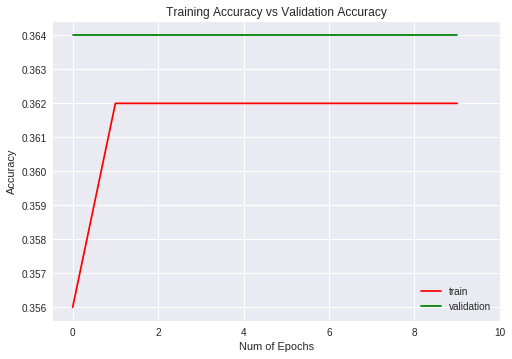

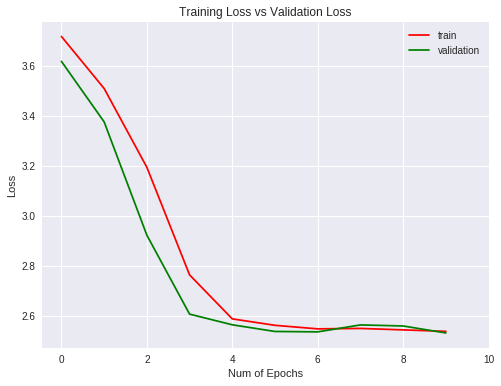

In [0]:
import matplotlib.pyplot as plt

plt.figure(0)  
plt.plot(vgg16.history['acc'],'r')  
plt.plot(vgg16.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(vgg16.history['loss'],'r')  
plt.plot(vgg16.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

In [0]:
vgg16_pred = vgg16_model.predict(x_test, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16_pred, axis=1)  

2000/2000 [==============================] - 2s 1ms/step


In [0]:
y_test.shape

(2000, 45)

(31, 31)


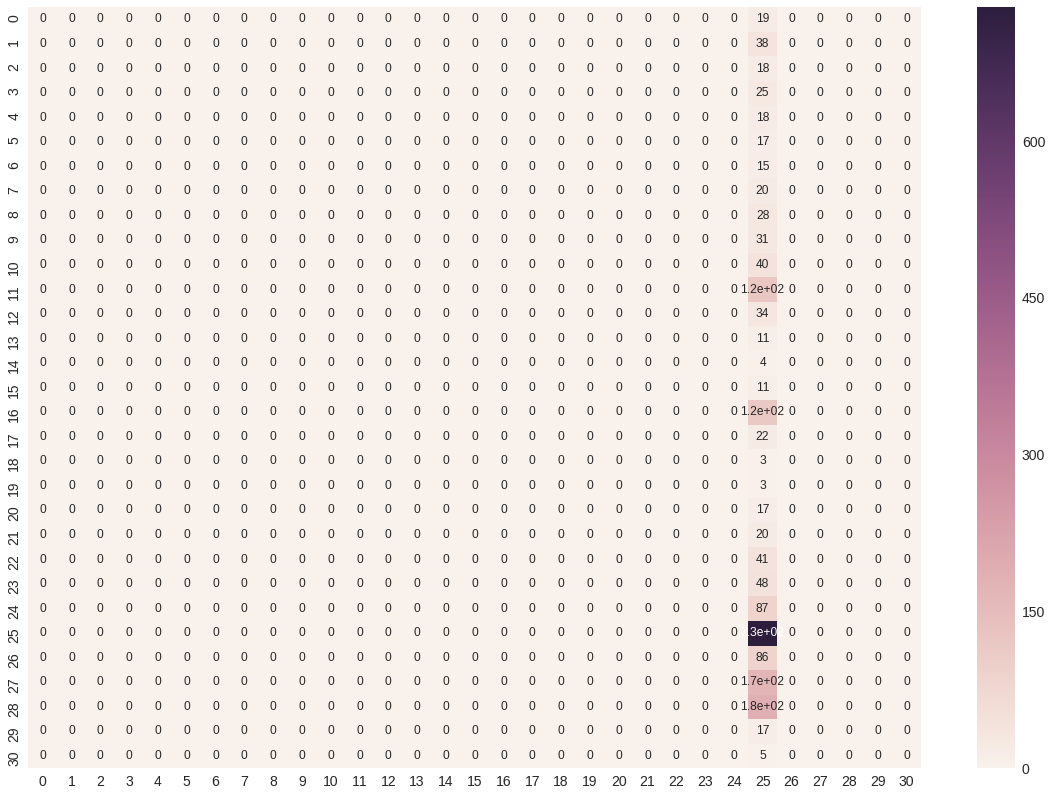

In [0]:
#Creamos la matriz de confusión
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

vgg16_cm = confusion_matrix(np.argmax(y_test, axis=1), vgg16_predicted)
print(vgg16_cm.shape)

# Visualiamos la matriz de confusión
vgg16_df_cm = pd.DataFrame(vgg16_cm, range(31), range(31))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg16_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

In [0]:
from sklearn.metrics import classification_report

vgg16_report = classification_report(np.argmax(y_test, axis=1), vgg16_predicted)  

print(vgg16_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00        31
          10       0.00      0.00      0.00        40
          11       0.00      0.00      0.00       120
          12       0.00      0.00      0.00        34
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00       119
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


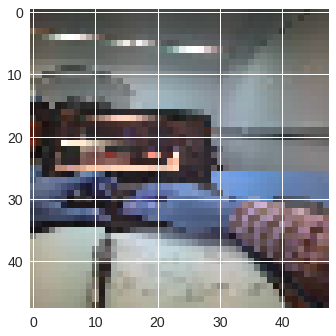

class for image 1: 27
predicted:         25


In [0]:
imgplot = plt.imshow(x_train[1])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[1])))  
print('predicted:         ' + str(vgg16_predicted[1]))  